# Anchor-Probe/Probe-Probe/Anchor-Anchor Output Distance
**Goal**: Analyze the distance between the output representation of anchors and their probes

In [1]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics.pairwise import cosine_distances, manhattan_distances
sns.set_style('darkgrid')

# Load Anchors and Probes Data

In [2]:
all_anchors_data = []
all_probes_data = []

for dilution in range(1, 4):
    # Load anchors data
    anchors_data = pd.read_pickle(f'pmsp-recurrent-dt-100-dilution-{dilution}-seed-1/activations-anchors-output.pkl')
    anchors_data = anchors_data[anchors_data['word_type'].isin(['ANC_REG', 'ANC_EXC', 'ANC_AMB'])].reset_index(drop=True)
    anchors_data['dilution'] = dilution

    # Load probes data
    probes_data = pd.read_pickle(f'pmsp-recurrent-dt-100-dilution-{dilution}-seed-1/activations-probes-output.pkl')
    probes_data['dilution'] = dilution

    all_anchors_data.append(anchors_data)
    all_probes_data.append(probes_data)

all_anchors_data = pd.concat(all_anchors_data)
all_probes_data = pd.concat(all_probes_data)

# Load anchor-probes mapping
anchor_probe_mapping = pd.read_pickle(f'../../dataset/anchor_probe_mapping_dilution_3.pkl')

In [3]:
all_anchors_data.head()

,epoch,output,word_id,orth,phon,word_type,target,dilution
0,1850,"[0.9997312, 0.0390018, 2.549195e-06, 0.0047450...",0,slit,slit,ANC_REG,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
1,1850,"[0.9997312, 0.0390018, 2.549195e-06, 0.0047450...",0,slit,slit,ANC_REG,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
2,1850,"[1.803647e-07, 0.008634246, 0.01695966, 0.0108...",1,thax,Tks,ANC_REG,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",1
3,1850,"[1.803647e-07, 0.008634246, 0.01695966, 0.0108...",1,thax,Tks,ANC_REG,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
4,1850,"[0.0003899396, 0.0001790656, 0.002647101, 0.00...",2,kleef,klEf,ANC_REG,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1


In [4]:
anchor_probe_mapping.head()

,anchor,probes,type
0,"[slit, dit, yit]","[vlit, plit, trit, drit]",REG
1,"[thax, chax, brax]","[frax, drax, prax, shrax]",REG
2,"[kleef, pleef, smeef]","[bleef, gleef, creef, preef]",REG
3,"[krim, plim, drim]","[blim, clim, shrim, frim]",REG
4,"[nisp, fisp, chisp]","[bisp, kisp, risp, tisp]",REG


In [5]:
all_probes_data['epoch'].unique()

array([1850, 1900, 1950, 2000, 2050, 2100, 2150, 2200, 2250, 2300, 2350,
       2400, 2450, 2500, 2550, 2600, 2650, 2700, 2750, 2800, 2850, 2900,
       2950, 3000, 3050, 3100, 3150, 3200, 3250, 3300, 3350, 3400, 3450,
       3500, 3550, 3600, 3650, 3700, 3750, 3800, 3850])

## Calculation of Distance between Anchors and Probes

We use two distance metrics - cosine distance, and L1 distance. The documentation for these two distance metrics are available here:
* [Cosine Distance](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_distances.html#sklearn.metrics.pairwise.cosine_distances)
* [Manhattan Distance](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.manhattan_distances.html#sklearn.metrics.pairwise.manhattan_distances)

In [6]:
results = []
for dilution in [1, 2, 3]:
    anchors_data = all_anchors_data[all_anchors_data['dilution'] == dilution]
    probes_data = all_probes_data[all_probes_data['dilution'] == dilution]

    for i, row in tqdm(anchor_probe_mapping.iterrows(), total=len(anchor_probe_mapping), desc=f"Dilution {dilution}"):
        anchor_output = anchors_data[anchors_data['orth'].isin(row['anchor'])]
        probes_output = probes_data[probes_data['orth'].isin(row['probes'])]

        min_epoch = min(anchor_output['epoch'].unique())
        max_epoch = max(anchor_output['epoch'].unique())

        for epoch in [min_epoch, max_epoch]:
            epoch_anchor_output = np.array(anchor_output[anchor_output['epoch'] == epoch]['output'].tolist())
            epoch_probe_output = np.array(probes_output[probes_output['epoch'] == epoch]['output'].tolist())

            results.append({
                'epoch': epoch,
                'dilution': dilution,
                'anchor': row['anchor'],
                'probes': row['probes'],
                'type': row['type'],
                'ap_cosine_distances': cosine_distances(epoch_anchor_output, epoch_probe_output),
                'ap_l1_distances': manhattan_distances(epoch_anchor_output, epoch_probe_output),
                'aa_cosine_distances': cosine_distances(epoch_anchor_output, epoch_anchor_output),
                'aa_l1_distances': manhattan_distances(epoch_anchor_output, epoch_anchor_output),
                'pp_cosine_distances': cosine_distances(epoch_probe_output, epoch_probe_output),
                'pp_l1_distances': manhattan_distances(epoch_probe_output, epoch_probe_output),
            })

Dilution 3: 100%|██████████| 27/27 [00:00<00:00, 63.19it/s]


In [7]:
results_df = pd.DataFrame(results)
results_df['mean_ap_cosine_distance'] = results_df['ap_cosine_distances'].apply(lambda x: x.mean())
results_df['mean_ap_l1_distance'] = results_df['ap_l1_distances'].apply(lambda x: x.mean())
results_df['mean_aa_cosine_distance'] = results_df['aa_cosine_distances'].apply(lambda x: x.mean())
results_df['mean_aa_l1_distance'] = results_df['aa_l1_distances'].apply(lambda x: x.mean())
results_df['mean_pp_cosine_distance'] = results_df['pp_cosine_distances'].apply(lambda x: x.mean())
results_df['mean_pp_l1_distance'] = results_df['pp_l1_distances'].apply(lambda x: x.mean())
results_df['first_anchor'] = results_df['anchor'].apply(lambda x: x[0])
results_df = results_df.sort_values(by=['type', 'first_anchor']).reset_index(drop=True)

In [8]:
results_df.head()

,epoch,dilution,anchor,probes,type,ap_cosine_distances,ap_l1_distances,aa_cosine_distances,aa_l1_distances,pp_cosine_distances,pp_l1_distances,mean_ap_cosine_distance,mean_ap_l1_distance,mean_aa_cosine_distance,mean_aa_l1_distance,mean_pp_cosine_distance,mean_pp_l1_distance,first_anchor
0,1850,1,"[blome, clome, flome]","[stome, shome, grome, prome]",AMB,"[[0.748737382937974, 0.7081654818790502, 0.497...","[[6.152499383301597, 5.0206506128419, 4.090518...","[[0.0, 2.220446049250313e-16], [2.220446049250...","[[0.0, 0.0], [0.0, 0.0]]","[[0.0, 0.4216295847944125, 0.7392007408548044,...","[[0.0, 3.144550553717102, 6.063925866764701, 6...",0.612805,4.826726,1.110223e-16,0.000000,0.444737,3.424139,blome
1,3850,1,"[blome, clome, flome]","[stome, shome, grome, prome]",AMB,"[[0.560509595028247, 0.5432567631405711, 0.509...","[[4.7100692049833, 4.475746550778198, 4.412342...","[[0.0, 0.0], [0.0, 0.0]]","[[0.0, 0.0], [0.0, 0.0]]","[[0.0, 0.5362403416128774, 0.5500454920083261,...","[[0.0, 4.0131662994089, 4.845503573056299, 4.6...",0.554788,4.609295,0.000000e+00,0.000000,0.387961,3.141767,blome
2,1850,2,"[blome, clome, flome]","[stome, shome, grome, prome]",AMB,"[[0.748737382937974, 0.7081654818790502, 0.497...","[[6.152499383301597, 5.0206506128419, 4.090518...","[[0.0, 1.1102230246251565e-16, 0.4975027312210...","[[0.0, 0.0, 4.0390947605896, 4.0390947605896],...","[[0.0, 0.4216295847944125, 0.7392007408548044,...","[[0.0, 3.144550553717102, 6.063925866764701, 6...",0.608011,4.824014,2.487514e-01,2.019547,0.444737,3.424139,blome
3,3850,2,"[blome, clome, flome]","[stome, shome, grome, prome]",AMB,"[[0.5009092275422891, 0.6188182377924116, 0.52...","[[4.5518723474718, 4.7693963776418995, 4.41336...","[[0.0, 0.0, 0.25111203132790283, 0.25111203132...","[[0.0, 0.0, 2.2112697417452996, 2.211269741745...","[[0.0, 0.5716896897786963, 0.5295183473481951,...","[[0.0, 4.283864075450098, 4.595306610692698, 3...",0.518110,4.234181,1.255560e-01,1.105635,0.359422,2.801205,blome
4,1850,3,"[blome, clome, flome]","[stome, shome, grome, prome]",AMB,"[[0.748737382937974, 0.7081654818790502, 0.497...","[[6.152499383301597, 5.0206506128419, 4.090518...","[[0.0, 1.1102230246251565e-16, 0.4975027312210...","[[0.0, 0.0, 4.0390947605896, 4.0390947605896, ...","[[0.0, 0.4216295847944125, 0.7392007408548044,...","[[0.0, 3.144550553717102, 6.063925866764701, 6...",0.635500,4.919888,2.962880e-01,2.384041,0.444737,3.424139,blome


## Mean Cosine and L1 Distance by Anchor/Probe Type

This first pair of graphs aggregate all three dilution levels together. The idea is that each anchor/probe set is weighted equally, and the dilution levels are weighted equally - i.e. each point of the curve is composed of 30 datapoints (3 dilution levels times 10 anchor sets) for REG/EXC and 21 datapoints for ambiguous.

The error bands are based on a confidence interval. The confidence interval being plotted is the 68% confidence interval - which approximately corresponds to standard error.

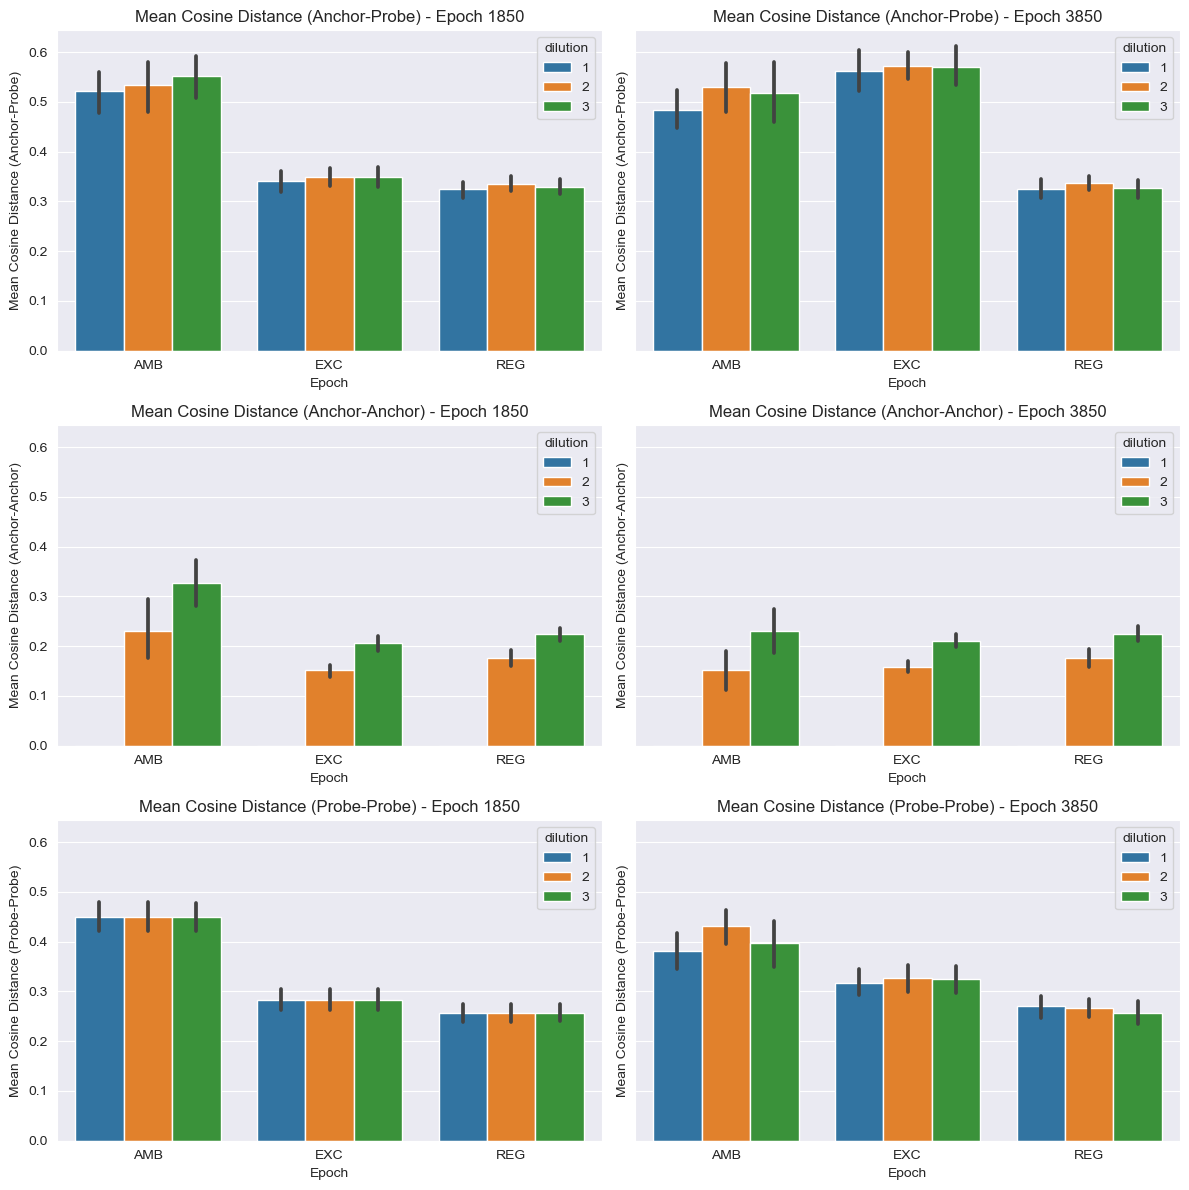

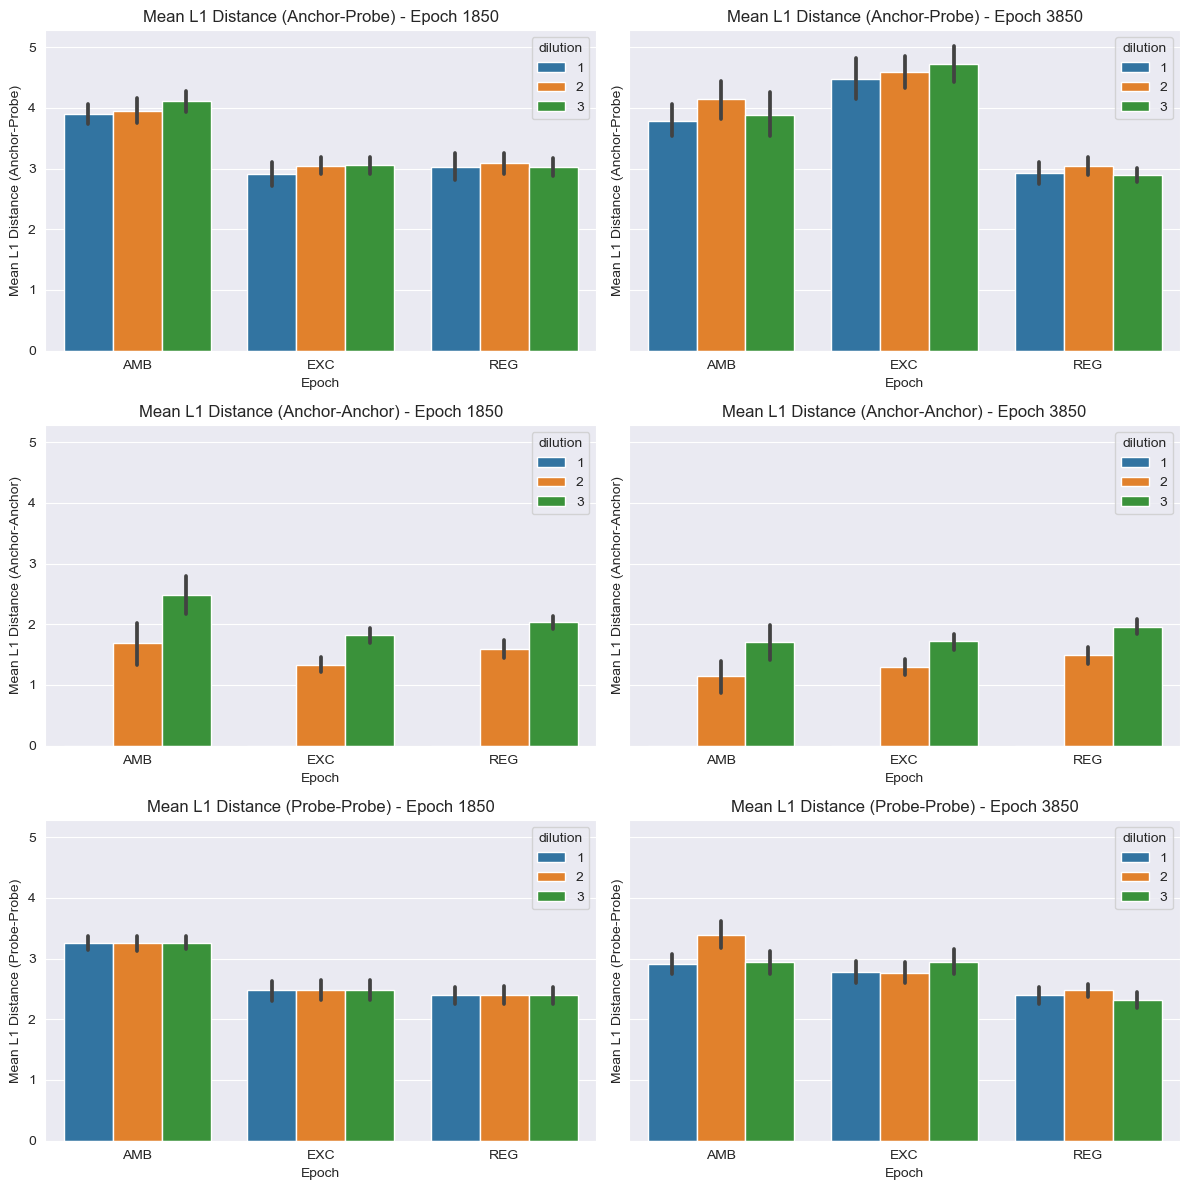

In [9]:
distance_mapping = {
    'aa': 'Anchor-Anchor',
    'ap': 'Anchor-Probe',
    'pp': 'Probe-Probe'
}

min_epoch = all_anchors_data['epoch'].min()
max_epoch = all_anchors_data['epoch'].max()

for metric in ['cosine', 'l1']:
    fig, axs = plt.subplots(3, 2, figsize=(12, 12), sharey='all')

    for distance, ax in zip(['ap', 'aa', 'pp'], axs):

        sns.barplot(data=results_df[results_df['epoch'] == min_epoch], x='type', y=f'mean_{distance}_{metric}_distance',
                    hue='dilution', ax=ax[0], ci=68)
        ax[0].set_xlabel('Epoch')
        ax[0].set_ylabel(f'Mean {metric.title()} Distance ({distance_mapping[distance]})')
        ax[0].set_title(f'Mean {metric.title()} Distance ({distance_mapping[distance]}) - Epoch {min_epoch}')

        sns.barplot(data=results_df[results_df['epoch'] == max_epoch], x='type', y=f'mean_{distance}_{metric}_distance',
                    hue='dilution', ax=ax[1], ci=68)
        ax[1].set_xlabel('Epoch')
        ax[1].set_ylabel(f'Mean {metric.title()} Distance ({distance_mapping[distance]})')
        ax[1].set_title(f'Mean {metric.title()} Distance ({distance_mapping[distance]}) - Epoch {max_epoch}')



    plt.tight_layout()
    plt.show()